# Chapter 3 - Gradient Descent

In [1]:
import sys
if 'google.colab' in sys.modules:
    !git clone https://github.com/jtooates/mlnb_public.git &> /dev/null
    !mv mlnb_public/* . &> /dev/null

In [2]:
%run Datasets.ipynb
%run Plot\ Utilities.ipynb
%run Chapter\ 2\ Utilities.ipynb
%run Animations.ipynb
import numpy as np
import json
import math

The last chapter introduced the Perceptron Learning Algorithm.  Although the operation of the algorithm made sense, the discussion was post hoc.  That is, given the algorithm, we sought to explain its behavior.  But where did the algorithm come from in the first place?  This chapter introduces a number of key concepts related to specifying what we want a machine learning algorithm to accomplish, and describes an approach to deriving the algorithm given that specification.  We'll apply that approach to derive the Perceptron algorithm from first principles.

The remainder of this chapter is organized as follows:
* Section 3.1 introduces the idea of a **loss function**, which is the means by which we tell a learning algorithm how to evaluate models.  One model that incurs less loss than another is a better model so, given a loss function, learning can be cast as function minimization.
* Section 3.2 describes **gradient descent**, a workhorse algorithm in machine learning that iteratively updates a model to minimize loss.
* Section 3.3 applies gradient descent to a particular loss function resulting in the (by now) familiar Perceptron update rule.
* Section 3.4 concludes and points to some ideas related to gradient descent that will be covered in future chapters.  We're definitely not done this with topic.

## 3.1 Loss Functions

Consider the dataset below shown below with three different separators.

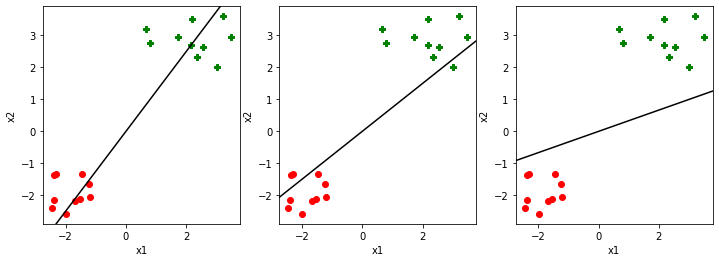

In [12]:
df2 = uniform_circle_dataset([(-2, -2), (2, 3)], [1, 1.5], 10)
plt.figure(figsize = (12, 4))
plt.axes().set_aspect('equal', 'box')
plt.subplot(1, 3, 1)
plot_2d(df2, weights = [-2.5, 2], show_separator = True, make_figure = False)
plt.subplot(1, 3, 2)
plot_2d(df2, weights = [-1.5, 2], show_separator = True, make_figure = False)
plt.subplot(1, 3, 3)
plot_2d(df2, weights = [-1, 3], show_separator = True, make_figure = False)

The leftmost separator is clearly, to us, not a good one.  It makes lots of mistakes, with both positive and negative instances on both side.  The middle separator seems better, with most of the red circles on one side and most of the green plusses on the other.  But the leftmost separator is the best because it does not make any mistakes on the training set.  The question that we address in this section is how to convey that information to a learning algorithm.  How do we allow the learning algorithm to evaluate the quality of a separator so that it can search for a good one? 

The idea is to write down a **loss function** that specifies how bad it is for the classifier to make mistakes and then cast learning as an optimization problem where the goal, in the case of the Perceptron, is to find a weight vector that minimizes the loss on the training data.  An example of a loss function is the 0-1 loss, shown in tabular form below.

|   $L_{0-1}$  | $\hat y = -1$ | $\hat y = 1$
| ----------- | ----------- | ----- |
| $y = -1$ | 0 | 1 |
| $y = 1$ | 1 | 0 |

For each of the four possible combinations of true ($y$) and predicted ($\hat y$) labels for a given instance, the table shows how much much loss is incurred.  It's called the 0-1 loss because the loss is 0 when the classifier is correct (i.e., $y = \hat y$) and the loss is 1 when the classifier is wrong ($y \neq \hat y$).  The sum of $L_{0-1}$ over a training set is just the number of misclassified instances, which we want to minimize.

The 0-1 loss is a function of two things, the true and predicted class labels, which can be written $L_{0-1}(y, \hat y)$.  For the Perceptron, $\hat y$ is a function of ${\bf w}$ and ${\bf x}$, so we can write the 0-1 loss as follows:

$$
L_{0-1}(y, {\bf w} \cdot {\bf x}) = \begin{cases}
0 & \text{if $y * {\bf w} \cdot {\bf x} > 0$}\\
1 & \text{otherwise}
\end{cases}
$$

If the signs of $y$ and ${\bf w} \cdot {\bf x}$ are the same, the instance is classified correctly and there is no loss, otherwise the loss is 1.  Because the $({\bf x}, y)$ pairs in the training set are given as input and fixed, the only way to change the loss is to modify ${\bf w}$.  This reduces the learning problem to finding a weight vector that minimizes the loss given the training data.

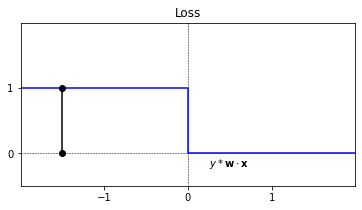

In [3]:
perceptron_loss_plot(ywx = -1.5)

$L_{0-1}$ is plotted above as a function of $y * {\bf w} \cdot {\bf x}$.  Note that the loss is 0 when the sign of $y * {\bf w} \cdot {\bf x}$ is positive, and the loss is 1 when the sign of $y * {\bf w} \cdot {\bf x}$ is negative.  The plot also shows the location of an instance for which $y * {\bf w} \cdot {\bf x} = -1.5$ and the associated loss.  You and I can look at the plot and think "clearly there is lower loss to the right of that point, so the algorithm just needs to modify the weight vector so that $y * {\bf w} \cdot {\bf x}$ increases".  But the learning algorithm does not have that global view of the loss surface.  To explore the loss for new weight vectors requires an evaluation of $L_{0-1}(y, {\bf w} \cdot {\bf x})$, and there are infinitely many possible weight vectors.  The plot below gives you some idea of what it is like to be a Perceptron with the 0-1 loss function and a misclassified instance.  You can compute the loss given the current weight vector and for weight vectors that are close to the current one, but they all look equally bad with a loss of 1.

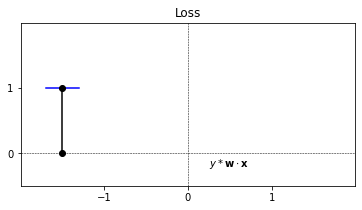

In [4]:
perceptron_loss_plot(ywx = -1.5, window = True)

The loss function needs to convey more information about how to modify the weights to reduce the loss.  The loss function plotted below, which we'll call the Perceptron loss and denote $L_p$, does just that.  It can be written as follows:

$$
L_{P}(y, {\bf w} \cdot {\bf x}) = \begin{cases}
0 & \text{if $y * {\bf w} \cdot {\bf x} > 0$}\\
-y * {\bf w} \cdot {\bf x} & \text{otherwise}
\end{cases}
$$

There is still 0 loss for correctly classified instances, but the loss for incorrectly classified instances is $-y * {\bf w} \cdot {\bf x}$.  Why?  First, note that $-y * {\bf w} \cdot {\bf x} > 0$ for misclassified instances, so the loss is a positive number.  Suppose the misclassified instance is negative.  Because it is misclassified, it sits in the positive half-plane defined by the weight vector.  Recall that the weight vector points in the direction of the positive half-plane.  Because ${\bf w} \cdot {\bf x}$ is proportional to the cosine of the angle between ${\bf w}$ and ${\bf x}$, as that angle gets smaller, ${\bf x}$ rotates to be more aligned with ${\bf w}$ and further away from the separating hyperplane, and ${\bf w} \cdot {\bf x}$ gets larger.  Therefore, the larger the value of $-y * {\bf w} \cdot {\bf x}$ for a negative instance that is misclassified, the further it is from the correct side of the  hyperplane. Similar reasoning leads to the same conclusion for positive instances that are misclassified.  The $L_P$ loss is thus proportional to the distance of the instance from the hyperplane and assigns more loss to instances for which the current weight vector is "more wrong".

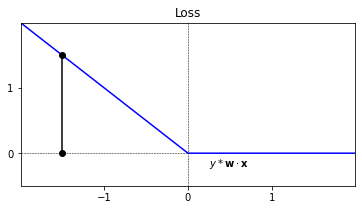

In [5]:
perceptron_loss_plot(ywx = -1.5, hinge = True)

The nice thing about the $L_P$ loss from a learning or optimization standpoint is that it provides useful information about how to modify the weights to reduce the loss.  The plot below again puts you in the shoes of a learning algorithm that has to figure out how to reduce the loss for a misclassified instance.  Now it's clear that "moving to the right" will reduce the loss using just local information.

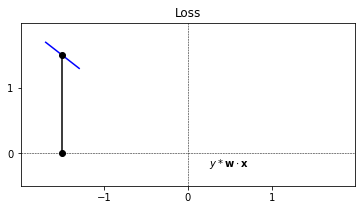

In [6]:
perceptron_loss_plot(ywx = -1.5, hinge = True, window = True)

## 3.2 Gradient Descent

The last piece of the puzzle is an automated way to compute weight updates that reduce the loss.  In this case, and many others we'll come across, that means using **gradient descent**, which is an iterative optimization algorithm.  We'll introduce the main concepts by way of a simple example and then apply gradient descent to derive the Perceptron update rule.

Suppose you're given the function $f(w) = (w - 4)^2 + 1$ and asked to find the value of $w$ that minimizes $f$.  Think of $f$ as a loss function and $w$ as a weight.  The goal is to find the weight that minimizes the loss.  Ignore for the moment that there is a simple analytical solution to this problem.  That is typically not the case for loss functions used in machine learning.  Gradient descent requires the function to be differentiable, which this one is with $f'(x) = 2(w - 4)$, and an initial value for $w$, which is often chosen at random.  In this case, we'll use $w = 2.5$ as the initial guess.  The animation below shows this situation, with the function plotted in blue and the current value of $w$ and $f(w)$ shown with a black line from $(w, 0)$ to $(w, f(w))$.  You'll notice that the tangent to $f(w)$ is shown as well, which is crucial to the operation of the algorithm.

In [13]:
%%capture 
anim = GradientDescentAnim(lambda w: (w - 4)**2 + 1, [2, 6], 2.5)
anim.step_size = 0.1
afunc2 = anim.animate()

In [12]:
HTML(afunc2.to_jshtml())

The slope of the tangent line in the first frame of the animation is $f'(2.5) = 2(2.5 - 4) = -3$.  This linear or first-order approximation to the function at $w = 2.5$ suggests that increasing $w$ will cause $f(w)$ to decrease because the slope of the tangent line is negative.  That is, for small values of $\epsilon > 0$, we expect $f(2.5 + \epsilon) < f(2.5)$.  In contrast, if the initial guess for $w$ had been 5, the slope of the tangent line would be $f'(5) = 2(5 - 4) = 2$.  Because the slope of the tangent line at $w = 5$ is positive, decreasing $w$ will cause $f(w)$ to decrease and we expect $f(5 - \epsilon) < f(5)$.  In both cases, given the current value of $w$, adjusting $w$ by an amount that has the negative of the sign of $f'(w)$ leads to a smaller value of $f$.

In this simple case, gradient descent updates the weight using the following rule:

$$ w = w - \alpha * f'(w) $$

The new weight is just the old weight minus a constant multiple of the slope of the tangent line of the function at the old weight.  The constant multiple is called the **step size** or **learning rate**, and $\alpha \in (0, 1]$.  The steeper the tangent, the larger the value of $|f'(w)|$ and the larger the change in $w$.  Because the upate subtracts $\alpha f'(w)$, the change in $w$ has the opposite sign of the slope of the tangent, which we saw above leads to reducing $f(w)$ after the update.

What is the role of $\alpha$?  Gradient descent approximates the function at a point with a straight line.  Unless the function is in fact linear, the approximation gets increasingly less accurate the further you move from that point.  For larger values of $\alpha$, you take a larger step and can wind up at a point where the function has increased rather than decreased.

<div style="background-color:#FADBD8;">
<center>&lt;Explore&gt;</center></div>

If you haven't already done so, run the animation above.  You'll notice that $w$ moves from 2.5 toward 4, which is the value that minimizes the function.  It moves more quickly early on because the slope is larger.  The closer $w$ gets to the value the minimizes $f$, the smaller the slope of the tangent line and the smaller the update to $w$.  Now change the step size to 1.  What happens?  The weight oscillates between two values and never makes progress.  The first weight update is as follows:
$$
\begin{eqnarray}
w & = & w - \alpha * f'(w) \\
 & = & w - \alpha * 2 * (w - 4) \\
 & = & 2.5 - 1 * 2 * (2.5 - 4) \\
 & = & 5.5
\end{eqnarray}
$$
The next weight update is:
$$
\begin{eqnarray}
w & = & w - \alpha * f'(w) \\
 & = & w - \alpha * 2 * (w - 4) \\
 & = & 5.5 - 1 * 2 * (5.5 - 4) \\
 & = & 2.5
\end{eqnarray}
$$
And we're right back where we started.  The step was so large that it hopped right over the minimum to the other side of the parabola where the slope has the same magnitude but opposite sign.  This is precisely the kind of kind of behavior that can occur when $\alpha$ is too large, but it can get worse.  What happens if $\alpha > 1$ in the example above?  The value of $w$ takes larger and larger steps on each iteration, hopping back and forth over the minimum point and getting farther and farther away from it.  Eventually, the weights will get so large that the code will throw a floating point overflow exception.

Finally, try running gradient descent in the cells below.  What happens?  The function $f(w) = w^4 + 2w^3 -12w^2 -w2 +6$ has two valleys that have different heights.  Given the starting point, gradient descent moves in the right direction (downhill) but settles into a **local minimum**, a point where the slope of the tangent line is 0 that is not where the function takes on its smallest value.  Gradient descent is not guaranteed to find a **global minimum**, but if the step size is small enough it will find a local minimum.  There will be more to say about this is later chapters.

In [10]:
%%capture 
anim = GradientDescentAnim(lambda w: w**4 + 2*w**3 - 12*w**2 - 2*w + 6, [-5, 3], 0.25)
anim.step_size = 0.01
afunc3 = anim.animate()

In [11]:
HTML(afunc3.to_jshtml())

<div style="background-color:#FADBD8;">
<center>&lt;/Explore&gt;</center></div>

## 3.3 Using Gradient Descent to Derive the Perceptron Algorithm

We're finally ready to use gradient descent to derive the update rule for the Perceptron.  There are just two more details to work out, both of which are seen in the plot below.  The `perceptron_loss_plot_3d` function takes as input a vector of the form ${\bf x} = [x_1,x_2]$ and a class label $y$, and plots the $L_P$ loss as a function of ${\bf w} = [w_1, w_2]$.  The plot represents a **loss surface** that shows the loss for a single instace as a function of the weights.  Note that there is a large region in weight space where the loss is 0.  All of the weights in that region result in a positive dot product with the input vector and thus produce zero loss because the class label is positive.  In contrast, all of the weights in the sloped region result in a negative dot product with the input vector and thus produce positive loss.  It's easy to see that the farther a weight is from the flat region the more loss it incurs. 

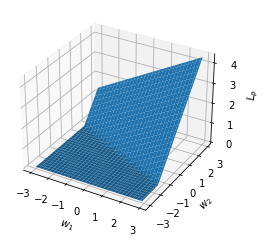

In [12]:
perceptron_loss_plot_3d([-0.5, -1], 1)

The first detail to work out is that the Perceptron maintains a weight vector, not just a single weight as in the examples above, and every element of that vector needs to be updated.  For each of the weights we want to know whether it should be increased or decreased, and by how much, to reduce the loss.  In the plot above, we need to compute updates for $w_1$ and $w_2$ given the current training instance, i.e., $({\bf x}, y)$.  That requires the use of the partial derivative of the loss with respect to each of the weights.  For example, the update rule for the $i^{th}$ weight, $w_i$, would be:

$$
w_i = w_i - \alpha \frac{\partial L_P}{\partial {w_i}}
$$

That is, we ask how $L_P$ changes as a function of $w_i$ if we hold all of the other weights constant and perform the standard update.  The **gradient** of a multi-variate function is just a vector of all of the partial derivatives with respect to each of the variables.  The gradient of the Perceptron loss is:

$$ 
\nabla L_P = \left(
\frac{\partial L_P}{\partial {w_0}},
\frac{\partial L_P}{\partial {w_1}}, \ldots, 
\frac{\partial L_P}{\partial {w_n}}
\right)
$$

The resulting vector-valued Perceptron update becomes:

$$
{\bf w} = {\bf w} - \alpha \nabla L_P
$$

The new weight vector is just the old weight vector minus a constant multiple of the slope of the tangent plane of the function at the old weight vector.

For the simple case with two weights shown in the $L_P$ plot above, the weight update looks like this:

$$ 
[w_1, w_2] = [w_1, w_2] - \alpha 
\left(
\frac{\partial L_P}{\partial {w_1}},
\frac{\partial L_P}{\partial {w_2}}
\right)
$$

The vector-valued update is just doing gradient descent on each of the individual weights, but it is written in a compact form.

Recall that $L_P$ is:

$$
L_{P}(y, {\bf w} \cdot {\bf x}) = \begin{cases}
0 & \text{if $y * {\bf w} \cdot {\bf x} > 0$}\\
-y * {\bf w} \cdot {\bf x} & \text{otherwise} 
\end{cases} 
$$

When $y * {\bf w} \cdot {\bf x} > 0$, the instance is classified correctly and $L_P$ is a constant (0) with zero slope in all directions so the gradient is:

$$
\nabla L_P = (0, 0, \ldots, 0)
$$

Using the vector valued update ${\bf w} = {\bf w} - \alpha \nabla L_P = {\bf w} - \alpha * (0, \ldots, 0) = {\bf w}$ results in no change to the weight vector when the instance is classified correctly.

When $y * {\bf w} \cdot {\bf x} \leq 0$, the instance is classified incorrectly so we need to compute the partial derivatives of $L_P$ with respect to each of the weights:

$$
\frac{\partial L_P}{\partial {w_i}} = 
\frac{\partial}{\partial {w_i}} \left(-y \sum_j w_j x_j \right) =
-y x_i
$$


Therefore, when the instance is misclassified the gradient is:

$$
\nabla L_P = (-y x_0, -y x_1, \ldots, -y x_n) = -y {\bf x}
$$

The vector valued update ${\bf w} = {\bf w} - \alpha \nabla L_P$ becomes ${\bf w} = {\bf w} + \alpha y {\bf x}$.  Setting $\alpha = 1$ gives precisely the Perceptron update!  For positive instances, ${\bf x}$ is added to the weight vector, and for negative instances, ${\bf x}$ is subtracted from the weight vector.

The final detail to work out is how to handle the fact that $L_P$ is not differentiable.  There is a discontinuity at ${\bf w} \cdot {\bf x} = 0$ that we've conveniently ignored up to this point.  That discontinuity is clearly visible in the plot above where the sloped plane where the instance is classified incorrectly meets the region in weight space where the instance is classified correctly (i.e., where $L_P = 0$).  There are infinitely many tangent planes that contain the line ${\bf w} \cdot {\bf x} = 0$, or in the plot above $-0.5 w_1 - w_2 = 0$.  Fortunately, the theory of subgradients says that we can choose any tangent plane that lower bounds $L_P$ and use its slope as the gradient in gradient descent.  One such plane is $L_P = 0$, which contains the half-plane where the classifier is correct for the instance.  Another such plane is $L_P = -y * {\bf w} \cdot {\bf x}$, which contains the half plane where the classifier is incorrect for the instance.  Choosing the latter subgradient at the point of discontinuity (i.e., where ${\bf w} \cdot {\bf x} = 0$) means that the vector valued update rule is precisely the update rule as originally presented in the algorithm above.

## 3.4 Final Thoughts

* Risk minimization
* Empirical risk minimization